## Mixture Density Networks with PyTorch ##

##### Based off of David Ha's original notebook

### Standard Data Fitting ###

In [2]:
import matplotlib.pyplot as plt # creating visualizations
import numpy as np # basic math and random numbers
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
from torch.autograd import Variable # storing data while learning
rdn = np.random.RandomState(33)
# TODO binarize the action space?

Then we generate random inputs $x$ to get random samples of $y(x)$. Later we will train a neural net on this data.

In [109]:
train_data = np.load("../train_2d_controller.npz")
# name of features [pos0,pos1,speed,angle,steer,gas,brake,diffy,diffx,steering,throttle]
# shape is [trace number, sequence, features]

estates = train_data['states']
# details is [episode, start, end, length of sequence from episode]
edetails = train_data['details']
# shuffle the indexes
limit=5
indexes = np.arange(estates.shape[0])[:limit]
rdn.shuffle(indexes)
# change to [timestep, batch, features]
states = estates[indexes].swapaxes(1,0)
details = edetails[indexes]

In [138]:
test_data = np.load("../test_2d_controller.npz")
# name of features [pos0,pos1,speed,angle,steer,gas,brake,diffy,diffx,steering,throttle]
# shape is [trace number, sequence, features]

vestates = test_data['states']
# details is [episode, start, end, length of sequence from episode]
vedetails = test_data['details']
# shuffle the indexes
vindexes = np.arange(vestates.shape[0])
rdn.shuffle(vindexes)
# change to [timestep, batch, features]
vstates = vestates[vindexes].swapaxes(1,0)
vdetails = vedetails[vindexes]

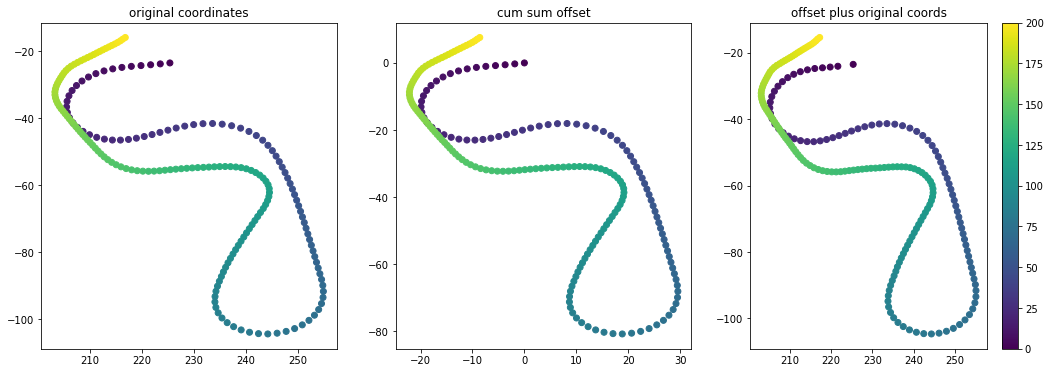

In [5]:
# check that feature array for offset is corre
e = min(limit-1,23)
syo = states[:,e,0]
sxo = states[:,e,1]
syod = states[:,e,7]+states[:,e,0]
sxod = states[:,e,8]+states[:,e,1]
syoc=np.cumsum(states[:,e,7])
sxoc=np.cumsum(states[:,e,8])

f,ax=plt.subplots(1,3, figsize=(18,6))
# original coordinates
ax[0].scatter(syo, sxo, c=np.arange(syo.shape[0]))
ax[0].set_title("original coordinates")
ax[1].scatter(syoc,sxoc, c=np.arange(syoc.shape[0]))
ax[1].set_title('cum sum offset')
oo = ax[2].scatter(syod,sxod, c=np.arange(syod.shape[0]))
ax[2].set_title('offset plus original coords')
# color is timestep
f.colorbar(oo,ax=ax[2])

In [6]:

hidden_size = 128
output_size = 2
batch_size = 5
history_size = 4
input_size = 9*history_size
mse_loss = nn.MSELoss()


In [72]:
class LSTM(nn.Module):
    def __init__(self, input_size=9, output_size=2, hidden_size=128):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTMCell(input_size, hidden_size)
        self.lstm2 = nn.LSTMCell(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, xt, h1_tm1, c1_tm1, h2_tm1, c2_tm1):
        h1_t, c1_t = self.lstm1(xt, (h1_tm1, c1_tm1))
        h2_t, c2_t = self.lstm2(h1_t, (h2_tm1, c2_tm1))
        output = self.linear(h2_t)
        return output, h1_t, c1_t, h2_t, c2_t


def train(x, y, e,do_save=False):
    optim.zero_grad()
    h1_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    c1_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    h2_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    c2_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    outputs = []
    losses = []
    # one batch of x
    
    for i in np.arange(0,x.shape[0]-history_size):
        xin = x[i:i+history_size].reshape(x.shape[1],history_size*x.shape[2])
        output, h1_tm1, c1_tm1, h2_tm1, c2_tm1 = lstm(xin, h1_tm1, c1_tm1, h2_tm1, c2_tm1)
        outputs+=[output]
    y_pred = torch.stack(outputs, 0)
    mse_loss = ((y_pred-y[:-history_size])**2).mean()
    mse_loss.backward()
    losses.append(mse_loss.data)
    clip = 10
    for p in lstm.parameters():
        p.grad.data.clamp_(min=-clip,max=clip)
    optim.step()
    return y_pred, np.mean(losses)



In [43]:
lstm = LSTM(input_size=input_size, output_size=output_size, hidden_size=hidden_size)
optim = torch.optim.Adam(lstm.parameters())

In [44]:
# change data type and shape, move from numpy to torch
# note that we need to convert all data to np.float32 for pytorch
x_tensor = torch.from_numpy(np.float32(states[:-1,:,2:]))
y_tensor = torch.from_numpy(np.float32(states[1:,:,7:9]))
x_variable = Variable(x_tensor, requires_grad=True)
y_variable = Variable(y_tensor, requires_grad=False)




In [139]:
# change data type and shape, move from numpy to torch
# note that we need to convert all data to np.float32 for pytorch
valid_x_tensor = torch.from_numpy(np.float32(vstates[:-1,:,2:]))
valid_y_tensor = torch.from_numpy(np.float32(vstates[1:,:,7:9]))
valid_x_variable = Variable(valid_x_tensor)
valid_y_variable = Variable(valid_y_tensor, requires_grad=False)

In [45]:
aloss = []
for e in range(1000):
    batch_loss = []
    #for bst in np.arange(0, x_variable.shape[1]-batch_size, batch_size, dtype=np.int):
    #    y_pred, mean_loss = train(x_variable[:,bst:bst+batch_size], y_variable[:,bst:bst+batch_size], e, False)
    y_pred, mean_loss = train(x_variable, y_variable, e, False)
    batch_loss.append(mean_loss)
    aloss.append(np.mean(batch_loss))
    if not e%100:
        print(e,aloss[-1])
    

0 1.1651216
100 0.021799956
200 0.009861648
300 0.006864159
400 0.004086896
500 0.0026424082
600 0.0022321476
700 0.0015732751
800 0.00084513874
900 0.0006359871
1000 0.0021669143
1100 0.00031315658
1200 0.00025454102
1300 0.0002704258
1400 0.0013571864
1500 0.0003354658
1600 0.0005020251
1700 0.00020528244
1800 0.0002774797
1900 0.000105778134
2000 0.13564341
2100 0.006071686
2200 0.002640441
2300 0.0015482419
2400 0.0010441171
2500 0.0007678876
2600 0.0005892113
2700 0.0005536606
2800 0.00054363825
2900 0.00032363192
3000 0.00028360274
3100 0.00023177057
3200 0.00046125386
3300 0.00024913883
3400 0.00018149914
3500 0.00015324295
3600 0.0001334041
3700 0.00026440437
3800 0.00012194942
3900 0.0007681646
4000 9.969618e-05
4100 9.500218e-05
4200 9.561869e-05
4300 8.5513166e-05
4400 8.930983e-05
4500 9.1144604e-05
4600 0.00069666107
4700 0.00015332978
4800 7.016095e-05
4900 6.7727575e-05


In [147]:
def teacher_force_predict(x, y, e,do_save=False):
    # not done
    optim.zero_grad()
    h1_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    c1_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    h2_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    c2_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    outputs = []
    losses = []
    # one batch of x
    for i in np.arange(0,x.shape[0]-history_size):
        xin = x[i:i+history_size].reshape(x.shape[1],history_size*x.shape[2])
        output, h1_tm1, c1_tm1, h2_tm1, c2_tm1 = lstm(xin, h1_tm1, c1_tm1, h2_tm1, c2_tm1)
        outputs+=[output]
    y_pred = torch.stack(outputs, 0)
    mse_loss = ((y_pred-y[:-history_size])**2).mean()
    losses.append(mse_loss.data)
    return y_pred, np.mean(losses)

In [95]:
tf_predict_losses = []
cnt = 0
tf_predicts = np.zeros((y_variable.shape[0]-history_size,y_variable.shape[1], y_variable.shape[2]))
tf_trues = np.zeros((y_variable.shape[0]-history_size,y_variable.shape[1], y_variable.shape[2]))
tf_input_inds = []

#for bst in np.arange(0, x_variable.shape[1]-batch_size, batch_size, dtype=np.int):
#    input_inds.extend(range(bst,bst+batch_size))
#    y_pred, mean_loss = predict(x_variable[:,bst:bst+batch_size], y_variable[:,bst:bst+batch_size], 0, False)
#    predicts[:,bst:bst+batch_size, :] = y_pred.detach().numpy()
#    trues[:,bst:bst+batch_size, :] = y_variable[:,bst:bst+batch_size].detach().numpy()
#    predict_losses.append(mean_loss)
#    cnt+=1
# get final not caught in batch
#if cnt < x_variable.jjjkshape[1]:
#    input_inds.extend(range(bst+batch_size, x_variable.shape[1]))
#    y_pred, mean_loss = predict(x_variable[:,bst+batch_size:], y_variable[:,bst+batch_size:], 0, False)
#    predicts[:,bst+batch_size:, :] = y_pred.detach().numpy()
#    trues[:,bst+batch_size:, :] = y_variable[:,bst+batch_size:].detach().numpy()
#    predict_losses.append(mean_loss)

y_pred, mean_loss = teacher_force_predict(x_variable, y_variable, 0, False)
tf_predicts[:,:, :] = y_pred.detach().numpy()
tf_trues = y_variable.detach().numpy()
tf_predict_losses.append(mean_loss)

In [ ]:
def predict(x, y, e,do_save=False):
    # not done
    optim.zero_grad()
    h1_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    c1_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    h2_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    c2_tm1 = Variable(torch.zeros((batch_size, hidden_size)))
    outputs = []
    losses = []
    input_data = x[:history_size].reshape(x.shape[1],history_size*x.shape[2])
    # one batch of x
    for i in np.arange(0,x.shape[0]-history_size):
        output, h1_tm1, c1_tm1, h2_tm1, c2_tm1 = lstm(input_data, h1_tm1, c1_tm1, h2_tm1, c2_tm1)
        outputs+=[output]
        input_data = input_data.reshape(history_size, x.shape[1], x.shape[2])
        # replace the offset with the predicted offset
        last_state_est = x[i]
        last_state_est[:,5:7] = output
        input_data = torch.cat((input_data[1:], last_state_est[None]), 0).reshape(x.shape[1],history_size*x.shape[2])
      
    y_pred = torch.stack(outputs, 0)
    #print(y_pred.shape)
    mse_loss = ((y_pred-y[:-history_size])**2).mean()
    losses.append(mse_loss.data)
    return y_pred, np.mean(losses)

In [123]:
# predict from training set
predict_losses = []
cnt = 0
#predicts = np.zeros((y_variable.shape[0]-history_size,y_variable.shape[1], y_variable.shape[2]))
#trues = np.zeros((y_variable.shape[0]-history_size,y_variable.shape[1], y_variable.shape[2]))
input_inds = []


y_pred, mean_loss = predict(x_variable, y_variable, 0, False)
predicts  = y_pred.detach().numpy()
trues = y_variable.detach().numpy()
predict_losses.append(mean_loss)

Text(0.5,1,'predict')

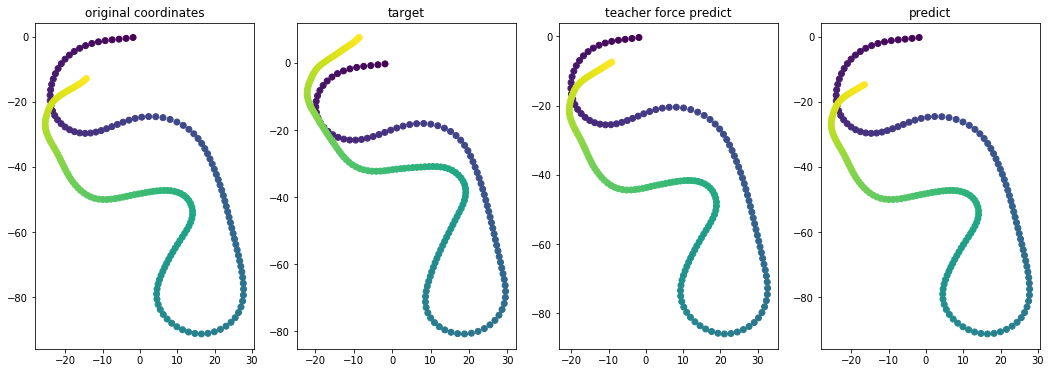

In [153]:
# check that feature array for offset is correct from training set
e = 4
d = details[e][3]-1
syo = np.cumsum(x_variable[:,e,5].detach().numpy())
sxo = np.cumsum(x_variable[:,e,6].detach().numpy())

syoc = np.cumsum(trues[:,e,0])
sxoc = np.cumsum(trues[:,e,1])

syodtf = np.cumsum(tf_predicts[:,e,0])
sxodtf = np.cumsum(tf_predicts[:,e,1])

syod = np.cumsum(predicts[:,e,0])
sxod = np.cumsum(predicts[:,e,1])

f,ax=plt.subplots(1,4, figsize=(18,6))
## original coordinates
_=ax[0].scatter(syo,sxo, c=np.arange(syo.shape[0]))
ax[0].set_title("original coordinates")
ax[1].scatter(syoc,sxoc, c=np.arange(syoc.shape[0]))
ax[1].set_title('target')
ax[2].scatter(syodtf,sxodtf, c=np.arange(syodtf.shape[0]))
ax[2].set_title('teacher force predict')
oo = ax[3].scatter(syod, sxod, c=np.arange(syod.shape[0]))
ax[3].set_title('predict')
# color is timestep
#f.colorbar(oo,ax=ax[3])

In [150]:
# tf predict from validation set

cnt = 0
vtfdshape = (valid_y_variable.shape[0]-history_size,valid_y_variable.shape[1], valid_y_variable.shape[2])
vtfpredicts = np.zeros(vdshape)
vtftrues = np.zeros(vdshape)
vtfinput_inds = []
vtfpredict_losses = []

y_pred, mean_loss = teacher_force_predict(valid_x_variable[:,:batch_size], valid_y_variable[:,:batch_size], 0, False)
vtfpredicts = y_pred.detach().numpy()
vtftrues = valid_y_variable.detach().numpy()
vtfpredict_losses.append(mean_loss)

In [144]:
# predict from validation set

cnt = 0
vdshape = (valid_y_variable.shape[0]-history_size,valid_y_variable.shape[1], valid_y_variable.shape[2])
vpredicts = np.zeros(vdshape)
vtrues = np.zeros(vdshape)
vinput_inds = []
vpredict_losses = []

y_pred, mean_loss = predict(valid_x_variable[:,:batch_size], valid_y_variable[:,:batch_size], 0, False)
vpredicts = y_pred.detach().numpy()
vtrues = valid_y_variable.detach().numpy()
vpredict_losses.append(mean_loss)

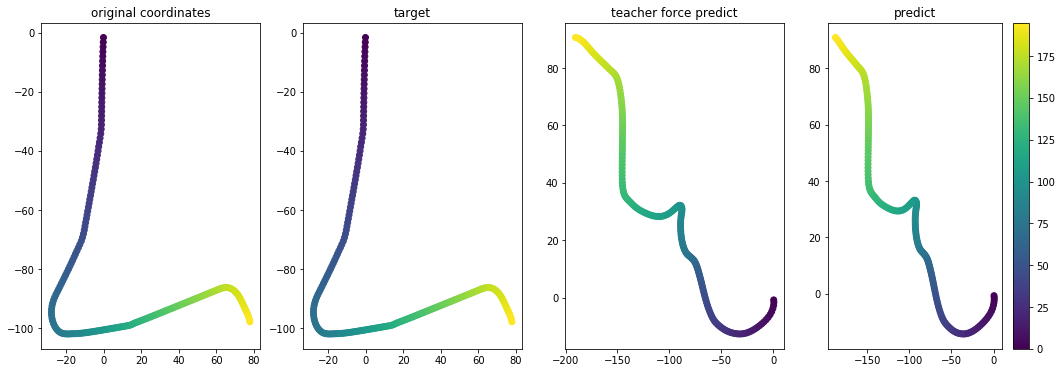

In [152]:
# check that feature array for offset is corre
e = 2
d = details[e][3]-1
syo = np.cumsum(valid_y_variable[:,e,0].detach().numpy())
sxo = np.cumsum(valid_y_variable[:,e,1].detach().numpy())

#syoc = np.cumsum(valid_x_variable[:,e,5].detach().numpy())
#sxoc = np.cumsum(valid_x_variable[:,e,6].detach().numpy())

syoc = np.cumsum(vtrues[:,e,0])
sxoc = np.cumsum(vtrues[:,e,1])

syodtf = np.cumsum(vtfpredicts[:,e,0])
sxodtf = np.cumsum(vtfpredicts[:,e,1])

syod = np.cumsum(vpredicts[:,e,0])
sxod = np.cumsum(vpredicts[:,e,1])

f,ax=plt.subplots(1,4, figsize=(18,6))
## original coordinates
_=ax[0].scatter(syo,sxo, c=np.arange(syo.shape[0]))
ax[0].set_title("original coordinates")
ax[1].scatter(syoc,sxoc, c=np.arange(syoc.shape[0]))
ax[1].set_title('target')
ax[2].scatter(syodtf,sxodtf, c=np.arange(syodtf.shape[0]))
ax[2].set_title('teacher force predict')
oo = ax[3].scatter(syod, sxod, c=np.arange(syod.shape[0]))
ax[3].set_title('predict')
# color is timestep
f.colorbar(oo,ax=ax[3])

Let's see how it performs by processing some evenly spaced samples.

If we use the same method to fit this data, it won't work well because the network can't output multiple values for each input. Because we used mean squared error loss, the network will try to output the average output value for each input.

## Mixture Density Networks ##

Mixture Density Networks, developed by Christopher Bishop in the 1990s, are one way to produce multiple outputs from a single input. MDN predicts a *probability distribution* of possible output values. Then can sample several possible different output values for a given input.

This concept is quite powerful, and can be employed many current areas of machine learning research. It also allows us to calculate a sort of confidence factor in the predictions that the network is making.

The inverted sinusoid data we chose is not just a toy problem. In [the paper introducing MDNs](http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) an inverted sinusoid is used to describe the angle we need to move a robot arm to achieve a target location. MDNs are also used to model handwriting, where the next stroke is drawn from a probability distribution of multiple possibilities, rather than sticking to one prediction.

Bishop's implementation of MDNs will predict a class of probability distributions called Mixture of Gaussians or Gaussian Mixture Models, where the output value is modelled as a weighted sum of multiple Gaussians, each with different means and standard deviations.

So for each input $x$, we will predict a probability distribution function $P(y|x)$:

$P(y|x) = \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x))$

- $k$ is an index describing which Gaussian we are referencing. There are $K$ Gaussians total.
- $\sum_{k}^{K}$ is the summation operator. We sum every $k$ Gaussian across all $K$. You might also see $\sum_{k=0}^{K-1}$ or $\sum_{k=1}^{K}$ depending on whether an author is using zero-based numbering or not.
- $\Pi_k$ acts as a weight, or multiplier, for mixing every $k$ Gaussian. It is a function of the input $x$: $\Pi_k(x)$
- $\phi$ is the Gaussian function and returns the at $y$ for a given mean and standard deviation.
- $\mu_k$ and $\sigma_k$ are the parameters for the $k$ Gaussian: mean $\mu_k$ and standard deviation $\sigma_k$. Instead of being fixed for each Gaussian, they are also functions of the input $x$: $\mu_k(x)$ and $\sigma_k(x)$

All of $\sigma_{k}$ are positive, and all of the weights $\Pi$ sum to one:

$\sum_{k}^{K} \Pi_{k} = 1$

First our network must learn the functions $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ for every $k$ Gaussian. Then these functions can be used to generate individual parameters $\mu_k, \sigma_k, \Pi_k$ for a given input $x$. These parameters will be used to generate our pdf $P(y|x)$. Finally, to make a prediction, we will need to sample (pick a value) from this pdf.

In our implementation, we will use a neural network of one hidden layer with 20 nodes. This will feed into another layer that generates the parameters for 5 mixtures: with 3 parameters $\Pi_k$, $\mu_k$, $\sigma_k$ for each Gaussian $k$.

Our definition will be split into three parts.

First we will compute 20 hidden values $z_h$ from our input $x$.

$z_h(x) = \tanh( W_{in} x + b_{in})$

Second, we will use these hidden values $z_h$ to compute our three sets of parameters $\Pi, \sigma, \mu$:

$
z_\Pi = W_{\Pi} z_h + b_{\Pi}\\
z_\sigma = W_{\sigma} z_h + b_{\sigma}\\
z_\mu = W_{\mu} z_h + b_{\mu}
$

Third, we will use the output of these layers to determine the parameters of the Gaussians.

$
\Pi = \frac{\exp(z_{\Pi})}{\sum_{k}^{K} \exp(z_{\Pi_k})}\\
\sigma = \exp(z_{\sigma})\\
\mu = z_{\mu}
$

- $\exp(x)$ is the exponential function also written as $e^x$

We use a [*softmax*](https://en.wikipedia.org/wiki/Softmax_function) operator to ensure that $\Pi$ sums to one across all $k$, and the exponential function ensures that each weight $\Pi_k$ is positive. We also use the exponential function to ensure that every $\sigma_k$ is positive.

Let's define our MDN network.

In [ ]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu

We cannot use the `MSELoss()` function for this task, because the output is an entire description of the probability distribution and not just a single value. A more suitable loss function is the logarithm of the likelihood of the output distribution vs the training data:

$loss(y | x) = -\log[ \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x)) ]$

So for every $x$ input and $y$ output pair in the training data set, we can compute a loss based on the predicted distribution versus the actual distribution, and then attempt the minimise the sum of all the costs combined. To those who are familiar with logistic regression and cross entropy minimisation of softmax, this is a similar approach, but with non-discretised states.

We have to implement this cost function ourselves:

In [ ]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

Let's create our MDN with 20 hidden nodes and 5 Gaussians.

In [ ]:
network = MDN(n_hidden=20, n_gaussians=5)

We'll use a different optimizer this time called Adam that is more suited to this task.

In [ ]:
optimizer = torch.optim.Adam(network.parameters())

We could generate more data to train the MDN, but what we have is nearly enough.

In [ ]:
mdn_x_data = y_data
mdn_y_data = x_data

mdn_x_tensor = y_tensor
mdn_y_tensor = x_tensor

x_variable = Variable(mdn_x_tensor)
y_variable = Variable(mdn_y_tensor, requires_grad=False)

Finally, let's define a new training loop. We need a training loop that can handle the new loss function, and the MDN needs to train longer than the previous network.

In [ ]:
def train_mdn(n_epochs=10000):
    for epoch in range(n_epochs):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(epoch, loss.data[0])

train_mdn()

Once the training is finished, we can observe all the parameters for the Gaussians and see how they vary with respect to the input $x$.

In [ ]:
pi_variable, sigma_variable, mu_variable = network(x_test_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$')
plt.xlim([-15,15])
plt.show()

We can also plot the $\mu$ of each Gaussian with respect to $x$, and show the range of by highlighting a region between $\mu-\sigma$ and $\mu+\sigma$.

In [ ]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In the plot above, we see that for every point on the $x$-axis, there are multiple lines or states where $y$ may be, and we select these states with probabilities modelled by $\Pi$. Note that the network won't find an ideal solution every time. It's possible to get lower loss by using more Gaussians, but the results are harder to interpret.

If we want to sample from the network we will need to pick a Gaussian $k$ and pick a value (sample) from that Gaussian. Here we use a trick called [Gumbel softmax sampling](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) to pick our $k$. We treat the $\Pi$ weights as a discrete distribution of probabilities, and sample one $k$ for each row of `pi_data`.

In [ ]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

Now that we have selected $k$ for each row, we can select $\sigma$ and $\mu$ as well. We will use `np.random.randn` to sample from each Gaussian, scaling it by $\sigma$ and offsetting it by $\mu$.

In [ ]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

With these sampled $y$ values, we can overlay them on the original distribution to see how accurately the network captures the shape.

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()

Some other things to try:
    
- What other constraints might we enforce? Is it ever helpful to encourage $\Pi$ to be sparse to maintain a "simple" distribution?
- What kinds of regularization can we add to the network?
- Often very small sigma can create problems, it might be helpful to add `sigma += 0.01` inside the MDN.
- How do more or fewer Gaussians affect the result?
- How do more or fewer hidden nodes affect the result?
- What other kinds of nonlinear activation functions work besides `Tanh()`? Try `Sigmoid()` too.
- How do these plots move if you draw them in realtime while the network is training?
- What happens when if you use the [*softplus*](https://en.wikipedia.org/wiki/Softplus) function for making the $\sigma$ positive, instead of $\exp(x)$?